20200731

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to compute the aperture correction for HST grism extraction when performing on a drz-blot flt frame.

# Background
Aperture correction for original flt frame of HST grisms was presented in ISRs. However, this correction might not be the same when the reduction is performed on a drz-blot flt frame. Theoretically, we would expect drz-blot flt objects to have different PSFs. Therefore, additional correction should be necessary when performing grism reduction on drz-blot flt frame.

# Objectives
- We would like to verify if a grism from drz-blot flt frame is different to that of original flt frame.
- If there is difference, 
 - how much is the difference quantitatively?
 - can we compute the correction values?
 
# Tasks
- Dataset:
 - idlk01jjq F110W 58754.1284439 False 0.0 0.0
 - idlk01jmq, idlk01joq, idlk01jpq, idlk01jrq: G102 4-point dither
- Procedure:
 1. Make flatfielded grism flt: Determine xyd to get flatfield of each grism image. Then, flatfield grism images before drizzling. 
   - Determine xyd
     - We identify 5 stars in the field. Check ds9.reg. GRB is also one in the ds9 region file, therefore there are 6 objects in the file.
     - S03 should be the best for testing the concept since i) it is isolated and only smooth background contamination presented, and ii) it is close to GRB.
   - Create flatfield image for each grism flt, and flatfield it
     - Name convention: NAME = rootname_sourcename
     - ./NAME/rootname_flt.fits is flatfield version of the original flt given sourcename.
 2. Drizzle and blot back: Use flatfield grism images, and reffile = idlk01jmq. Note that there would be original flt, median-blot flt, and drz-blot flt. We would like to create at least orignal and drz-blot types. Also, use pixfrac = 1 and native scale.
   - Drizzle
   - Blot to idlk01jmq flt frame
   - ./drzblot_S03/idlk01jmq_flt.fits is the final product from this step which is the original flt replaced with drz-blot value
 3. Determine the extraction region.
 4. Prepare clean images
   - Do we need background subtraction? Apply one background to all?
   - Prepare clean drz-blot image.
   - Prepare clean original flt images.
 5. Extract and compare 
- Metrics
 

In [1]:
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob,copy,os


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [2]:
def read_ds9region(ds9regfile):
    """
    Assume ds9regfile in the format as ds9, and coordinate system as image
    """
    out = {}
    f = open(ds9regfile,'r')
    for i,ii in enumerate(f.readlines()):
        if i < 3:
            continue
        x,y,_ = np.array(ii.split('(')[1].split(')')[0].split(',')).astype(float)
        z = ii.split('{')[1].split('}')[0]
        out[z] = (x,y)
    return out


In [3]:
from hstgrism.container import Container
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.show_overview import show_overview
import pandas as pd
import os

def generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                           xyd,confile,beam,gfile,dfile,
                           flatfile,
                           params_overview
                          ):
    """
    Use hstgrism to make flatfielded grism flt.
    """
    ##########
    # Make Container
    ##########
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)
    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG102(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=containerobj.data['saveprefix'],
                  save=True,
                  container=containerobj,
                  params=params_overview
                 )    
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # Make flatfield
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    bbdata = pd.read_csv(bbcorner)
    flatobj = FlatField(container=containerobj,flatfile=flatfile,xyref=tdata.xyref,dldp=tdata.dldp)
    flatobj.compute()
    flatobj.save(do_cutout=False)
    ##########
    # Make flatfielded flt
    ##########
    string = './{0}/{1}'.format(containerobj.data['savefolder'],gfile[0].split('/')[-1])
    os.system('cp {0} {1}'.format(gfile[0],string))
    gfile_new = (string,1)
    ffile = ('./{0}/{1}_fullflat.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
    tmp = fits.open(gfile_new[0])
    tmpdata = tmp[gfile_new[1]].data.copy()
    flatdata = fits.open(ffile[0])[ffile[1]].data.copy()
    m = np.isfinite(flatdata)
    tmpdata[m] = tmpdata[m] / flatdata[m]
    tmp[gfile_new[1]].data = tmpdata.copy()
    tmp.writeto(gfile_new[0],overwrite=True)
    print('Update flatfielded {0}'.format(gfile_new[0]))


# 1. Make flatfielded grism flt

In [4]:
fpath = '/Users/kbhirombhakdi/_work/_data/15089/mastDownload/HST'
tmp = glob.glob(fpath+'/*/idlk01*flt.fits')
flist = [tmp[0],tmp[2],tmp[3],tmp[5],tmp[1]]
for ii,i in enumerate(flist):
    h = fits.open(i)[0].header
    string = '{0} {1} {2} {3} {4} {5} {6}'.format(ii,h['ROOTNAME'],h['FILTER'],h['EXPSTART'],h['SUBARRAY'],
                       h['POSTARG1'],h['POSTARG2']
                      )
    print(string)


0 idlk01jjq F110W 58754.1284439 False 0.0 0.0
1 idlk01jmq G102 58754.13229834 False 0.0 0.0
2 idlk01joq G102 58754.1388376 False 0.54235 0.18176
3 idlk01jpq G102 58754.14537686 False 0.33891 0.48481
4 idlk01jrq G102 58754.1851802 False -0.20344 0.30304


{'GRB': (489.94651, 542.02967), 'S01': (621.20007, 551.05677), 'S02': (550.36337, 475.36442), 'S03': (610.08939, 413.55856), 'S04': (163.23836, 322.20776), 'S05': (356.08803, 961.90756)}


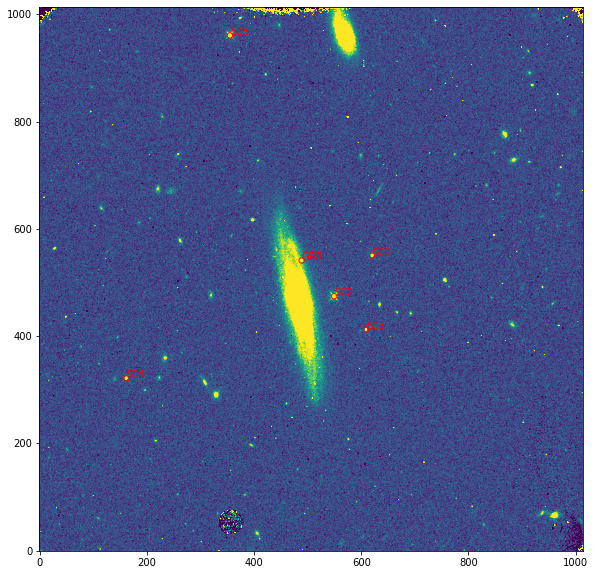

In [5]:
tmp = './ds9.reg'
sourcelist = read_ds9region(tmp)
print(sourcelist)

tmpdata = fits.open(flist[0])[1].data
plt.figure(figsize=(10,10))
m = np.isfinite(tmpdata)
vmin,vmax = np.percentile(tmpdata[m],5.),np.percentile(tmpdata[m],99.)
plt.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)

for i in sourcelist:
    x,y = sourcelist[i]
    plt.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    plt.annotate(i,(x-1,y-1),fontsize=10,color='red')


Save ./idlk01jmq_S03/idlk01jmq_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idlk01jmq_S03/idlk01jmq_S03_trace.csv
Save ./idlk01jmq_S03/idlk01jmq_S03_overview.pdf

Save ./idlk01jmq_S03/idlk01jmq_S03_tbox.csv
Save ./idlk01jmq_S03/idlk01jmq_S03_bbox.csv
Save ./idlk01jmq_S03/idlk01jmq_S03_bbcorner.csv
Save ./idlk01jmq_S03/idlk01jmq_S03_cutout.fits
Save ./idlk01jmq_S03/idlk01jmq_S03_mask.fits
Save ./idlk01jmq_S03/idlk01jmq_S03_fullflat.fits
Update flatfielded ./idlk01jmq_S03/idlk01jmq_flt.fits
Save ./idlk01joq_S03/idlk01joq_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idlk01joq_S03/idlk01joq_S03_trace.csv
Save ./idlk01joq_S03/idlk01joq_S03_overview.pdf

Save ./idlk01joq_S03/idlk01joq_S03_tbox.csv
Save ./idlk01joq_S03/idlk01joq_S03_bbox.csv
Save ./idlk01joq_S03/idlk01joq_S03_bbcorner.csv

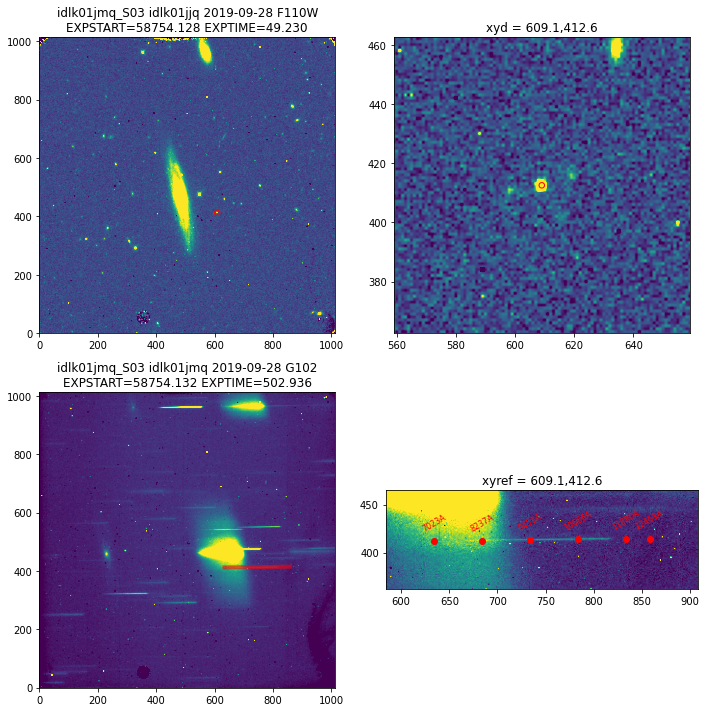

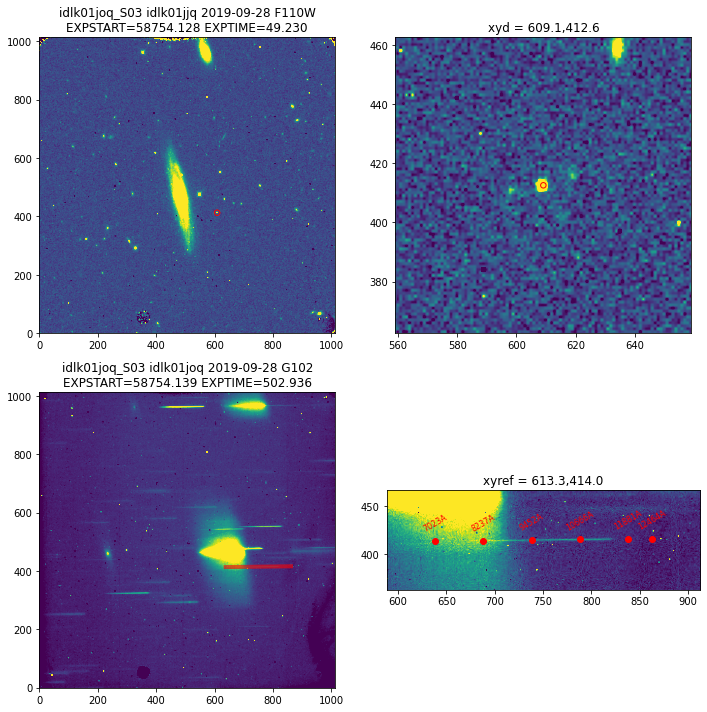

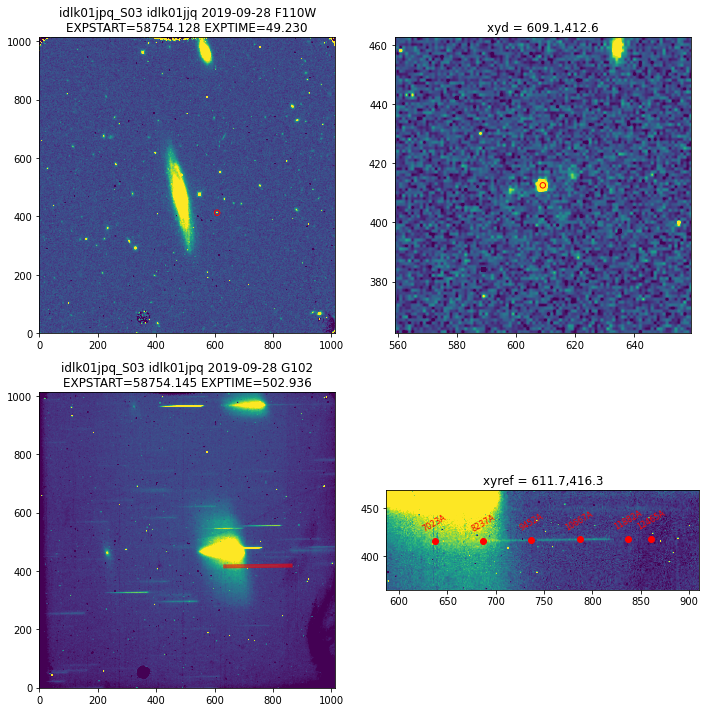

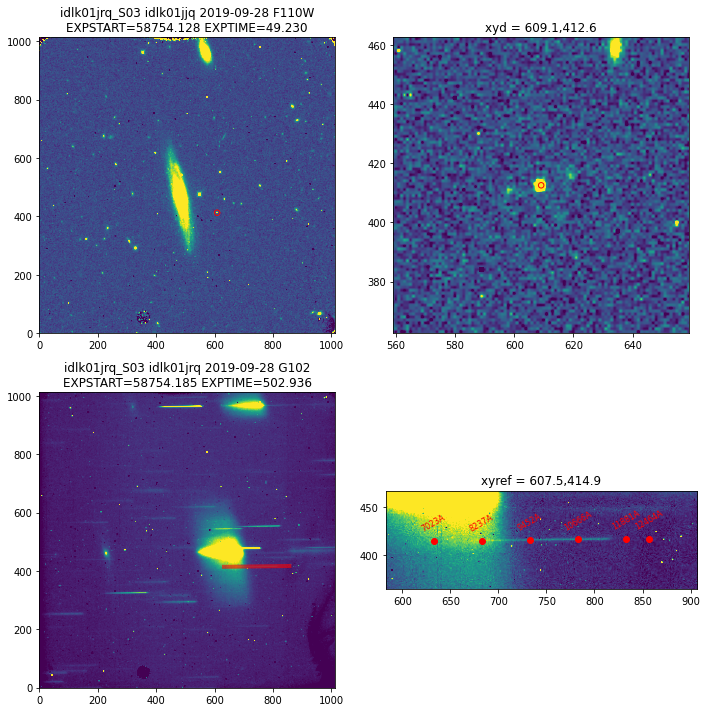

In [6]:
for i,ii in enumerate(flist):
    if i == 0:
        continue
    dfile = (flist[0],1)
    gfile = (flist[i],1)
    rootname = fits.open(gfile[0])[0].header['ROOTNAME']
    sourcename = 'S03'
    saveprefix = '{0}_{1}'.format(rootname,sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    x,y = sourcelist[sourcename]
    xyd = (x-1,y-1)
    beam = 'A'
    confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F110W.V4.32.conf'
    flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.flat.2.fits'
    params_overview = {'figsize': (10, 10), 
                       '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                       '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                       '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                       '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
    generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                               xyd,confile,beam,gfile,dfile,
                               flatfile,
                           params_overview
                              )


# 2. Drizzle and blot back

In [7]:
# make drzlist
drzlist = []
sourcename = 'S03'
for ii,i in enumerate(flist):
    if ii==0:
        continue
    tmp = i.split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,sourcename,tmp)
    drzlist.append(string)
drzlist


['./idlk01jmq_S03/idlk01jmq_flt.fits',
 './idlk01joq_S03/idlk01joq_flt.fits',
 './idlk01jpq_S03/idlk01jpq_flt.fits',
 './idlk01jrq_S03/idlk01jrq_flt.fits']

In [8]:
# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':False,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
          'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':False,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0],
              
         }
AstroDrizzle(input=drzlist,output=sourcename,**params_drz)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 17:18:57.93 (31/07/2020)

==== Processing Step  Initialization  started at  17:18:57.938 (31/07/2020)

Creating OUTPUT WCS from ./idlk01jmq_S03/idlk01jmq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.55874431413255e-05 1.10067261254017e-05
CD_21  CD_22: 1.22039593029989e-05 -3.1749628641053e-05
CRVAL    : 44.54406741220054 -8.956507658833223
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354386185945575
ORIENTAT : 160.87997048501853
********************************************************************************
*
*  Estimated memory usage:  up to 78 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 17:18:58.497 (31/07/2020)
==== Processing Step  Static Mask  started at  17

==== Processing Step Blot finished at 17:19:05.822 (31/07/2020)
==== Processing Step  Driz_CR  started at  17:19:05.82 (31/07/2020)

Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200731/idlk01jmq_S03/idlk01jmq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200731/idlk01jpq_S03/idlk01jpq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200731/idlk01joq_S03/idlk01joq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200731/idlk01jrq_S03/idlk01jrq_sci1_crmask.fits
==== Processing Step Driz_CR finished at 17:19:06.946 (31/07/2020)
==== Processing Step  Final Drizzle  started at  17:19:06.957 (31/07/2020)

WCS Keywords

CD_11  CD_12: 3.55874431413255e-05 1.10067261254017e-05
CD_21  CD_22: 1.22039593029989e-05 -3.1749628641053e-05
CRVAL    : 44.54406741220054 -8.956507658833223
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354386185945575
ORIENTAT : 160.87997048501853
-Generating multi-extension

In [9]:
# setup
drzfile = glob.glob('*drz.fits')[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname,sourcename = reffile.split('/')[1].split('_')
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(sourcename,rootname)
drzfile,reffile,skyval,outdata

('S03_drz.fits',
 './idlk01jmq_S03/idlk01jmq_flt.fits',
 0.6017626523971558,
 './drzblot_S03/idlk01jmq_drzblot_sci.fits')

In [10]:
# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(sourcename)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(flist[1],savefolder))
string = './{0}/{1}'.format(savefolder,flist[1].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)


Using coordinate transformation defined by user...


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Added 0.6017626523971558 counts back in to blotted image as sky.
Created output image: ./drzblot_S03/idlk01jmq_drzblot_sci.fits


# End
20200731 ends here with ./drzblot_S03/idlk01jmq_flt.fits to be used in the next step.
- Code needs verification.